In [3]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()
import numpy as np

In [6]:
def apply_secret_unitary(secret_unitary, qubit, quantum_circuit, dagger):
    function_map = {
        'h' : quantum_circuit.h,
        'x' : quantum_circuit.x,
        'y' : quantum_circuit.y,
        'z' : quantum_circuit.z,
        't' : quantum_circuit.t,
    }
    
    if dagger: 
        function_map['t'] = quantum_circuit.tdg
        
    if dagger:
        [function_map[unitary](qubit) for unitary in secret_unitary]
    else:
        [function_map[unitary](qubit) for unitary in secret_unitary[::-1]]

In [49]:
qc = QuantumCircuit(3, 3)

secret_unitary = 'hxz';

apply_secret_unitary(secret_unitary, qc.qubits[0], qc, dagger=0)
qc.barrier()

#Setting up entanglement between qubit 1 and qubit 2
qc.h(1)
qc.cx(1, 2)
qc.barrier()

#Alice does the following sequence of steps
qc.cx(0, 1)
qc.h(0)

#She then communicates the result of the measurement to Bob.
#Since we set up the value of qubits as |10>, Bob has to do a Z to recover the value.
qc.cx(1, 2)
qc.cz(0, 2)

apply_secret_unitary(secret_unitary, qc.qubits[2], qc, dagger=1)

qc.barrier()

qc.measure(0, 0)
qc.measure(1, 1)
qc.measure(2, 2)

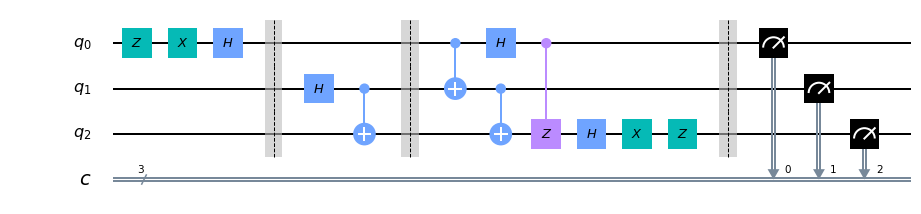

In [50]:
qc.draw()

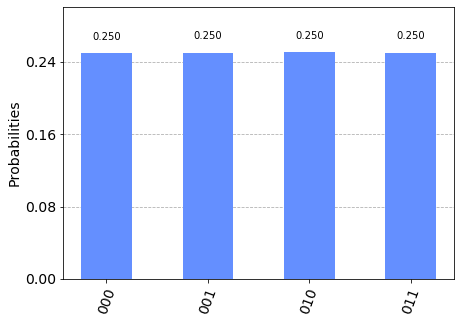

In [51]:
#Simulating on a quantum simulator
shots = 1000000
job = execute(qc, Aer.get_backend('qasm_simulator'), shots=shots)
counts = job.result().get_counts()
plot_histogram(counts)

In [54]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

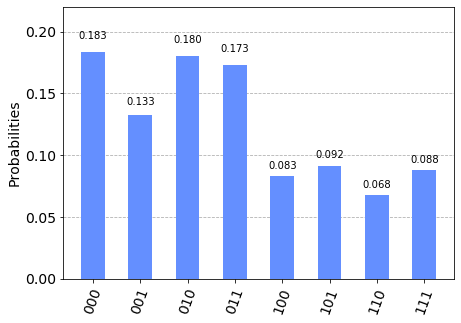

In [55]:
#Quantum teleportation on a real quantum computer
from qiskit.providers.ibmq import least_busy
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))

job_exp = execute(qc, backend=backend, shots=8192)
exp_result = job_exp.result()

counts = exp_result.get_counts()
plot_histogram(counts)